In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import entropy
import numpy as np

#fetch csv
file_path = '/Users/asger/Documents/GitHub/Deep_Learning_Techniques/Master/Data/final_dataset.csv'
df = pd.read_csv(file_path)

In [31]:
#daily price change
df['usd_eur_daily_change'] = df['usd_eur_exchange']

#remove first NA value bc of diff
df = df.dropna(subset=['usd_eur_daily_change'])

In [39]:
# Define the histogram analysis function
def histogram_analysis(close_diff, number_of_bins=10):
    # Perform histogram
    bin_counts, bin_edges = np.histogram(close_diff, bins=number_of_bins)
    bin_max_diff = bin_edges[1:]  # upper bin edges represent max differences
    
    # Reverse sort bin counts and corresponding max differences
    sorted_indices = np.argsort(bin_counts)[::-1]
    bin_counts = bin_counts[sorted_indices]
    bin_max_diff = bin_max_diff[sorted_indices]

    # Initialize variables
    temp_sum = 0
    sum_bin_counts = np.sum(bin_counts)
    i = 0
    
    # Iterate to find the threshold upper bound
    while i < number_of_bins:
        temp_sum += bin_counts[i]
        if temp_sum / sum_bin_counts > 0.85:
            break
        i += 1

    threshold_upper_bound = bin_max_diff[i]
    return threshold_upper_bound

# Define the entropy calculation function
def calculate_entropy(labels):
    # Calculate entropy using scipy's entropy function
    label_counts = np.bincount(labels.astype(int))
    # Normalize counts to get probabilities
    label_probs = label_counts / np.sum(label_counts)
    # Calculate entropy
    return entropy(label_probs, base=2)

# Define the threshold calculation function
def calculate_thresholds(close_diff):
    threshold_upper_bound = histogram_analysis(close_diff, 10)
    best_entropy = -np.inf
    best_thresholds = (0, 0)
    
    temp_threshold_1 = np.min(close_diff)  # Start from the minimum value of the data
    while temp_threshold_1 < threshold_upper_bound:
        temp_threshold_2 = temp_threshold_1 + 0.0001  # Ensure threshold_2 is always greater than threshold_1

        while temp_threshold_2 < threshold_upper_bound:
            labels = np.zeros(close_diff.shape, dtype=int)
            labels[close_diff < temp_threshold_1] = 1  # "Decrease"
            labels[close_diff > temp_threshold_2] = 2  # "Increase"

            current_entropy = calculate_entropy(labels)

            if current_entropy > best_entropy:
                best_entropy = current_entropy
                best_thresholds = (temp_threshold_1, temp_threshold_2)

            temp_threshold_2 += 0.0001  # Increment threshold by a small value
        
        temp_threshold_1 += 0.0001  # Increment threshold by a small value
    
    return best_thresholds

# Extract the daily changes excluding the first NaN value
close_diff = df['usd_eur_daily_change'].dropna().values

# Calculate the optimal thresholds
optimal_thresholds = calculate_thresholds(close_diff)

print(f"Optimal Thresholds: Decrease < {optimal_thresholds[0]}, Neutral between {optimal_thresholds[0]} and {optimal_thresholds[1]}, Increase > {optimal_thresholds[1]}")

Optimal Thresholds: Decrease < -0.004299999999999814, Neutral between -0.004299999999999814 and -0.0005999999999998164, Increase > -0.0005999999999998164


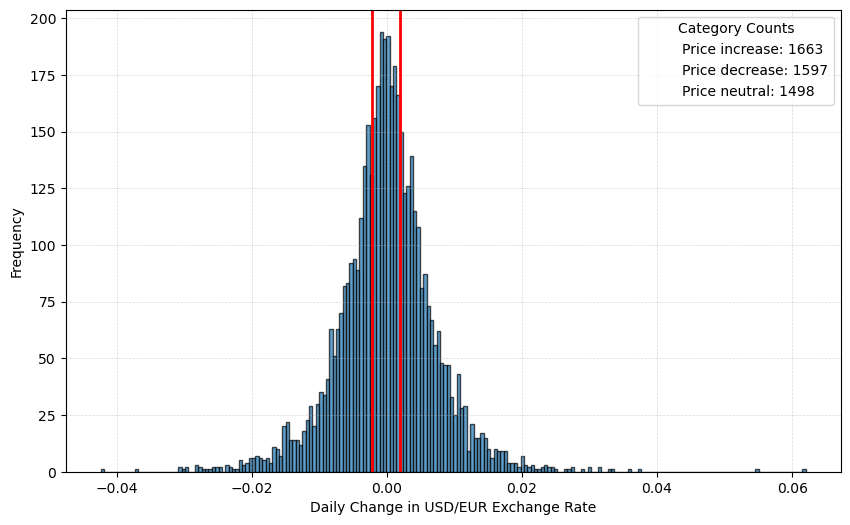

In [103]:
#remove first NA value bc of diff
df = df.dropna(subset=['usd_eur_daily_change'])

#defining quantiles (adjust this to desired)
q25 = df['usd_eur_daily_change'].quantile(0.34)
q75 = df['usd_eur_daily_change'].quantile(0.65)
#categorize function creation
def categorize_change(change, q25, q75):
    if change < q25:
        return 'Decrease'
    elif change > q75:
        return 'Increase'
    else:
        return 'Neutral'

# make new column with category and apply function
df['category'] = df['usd_eur_daily_change'].apply(categorize_change, args=(q25, q75))

#fetch count for each cat - used for legends later
counts = df['category'].value_counts()
increases = counts.get('Increase', 0)
decreases = counts.get('Decrease', 0)
neutrals = counts.get('Neutral', 0)

#plotting hist.
plt.figure(figsize=(10, 6))
plt.hist(df['usd_eur_daily_change'], bins=210, edgecolor='k', alpha=0.7)

#add threshold lines (qtiles)
plt.axvline(q25, color='r', linestyle='-', linewidth=2, label=f'25th Percentile: {q25:.3f}')
plt.axvline(q75, color='r', linestyle='-', linewidth=2, label=f'75th Percentile: {q75:.3f}')

#add legend
plt.legend(loc='upper left')

#make legend titles: count of each catergory displayed
custom_lines = [Line2D([0], [0], color='w', lw=0),
                Line2D([0], [0], color='w', lw=0),
                Line2D([0], [0], color='w', lw=0)]
category_labels = [f'Price increase: {increases}', f'Price decrease: {decreases}', f'Price neutral: {neutrals}']

plt.legend(custom_lines, category_labels, loc='upper right', title='Category Counts')

#labels
plt.xlabel('Daily Change in USD/EUR Exchange Rate')
plt.ylabel('Frequency')

#plot
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Adjust grid properties
plt.show()

In [104]:
print(q25, q75)

-0.0021999999999999 0.002
